Étude d'oscillations anharmoniques
==================================

**Date:** vendredi 18 février 2022



## Capacité numérique



-   à l’aide d’un langage de programmation, résoudre numériquement une
    équation différentielle du deuxième ordre nonlinéaire et faire
    apparaître l’effet des termes nonlinéaires.



## Modules



Au lieu d'utiliser la fonction `odeint`, on préférera la fonction
`solve_ivp` du même module offrant davantage de possibilités
([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp)), en particulier celle de déterminer les instants où
certains évènements sont réalisés.



In [1]:
%matplotlib inline

La ligne précédente ne doit apparaître que dans les notebooks
`Jupyter`, pas dans un fichier python.



In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Période du pendule simple



### Équation différentielle adimensionnée



On étudie l'exemple du pendule simple dont l'angle $\theta$ est
solution de l'équation différentielle d'ordre 2:

\begin{equation*}
  \frac{\mathrm{d} \theta}{\mathrm{d} t} +  \omega_{0}^{2} \sin(\theta) = 0,
\end{equation*}

avec $\omega_0^2 = g/\ell$. En introduisant la période des
oscillations de faible amplitude $T_0 = 2\pi/\omega_0$, on définit
la variable sans dimension $\tau = t/T_0$ pour réécrire l'équation
sous la forme:

\begin{equation*}
  \frac{\mathrm{d}^2 \theta}{\mathrm{d} \tau^2} +  (2 \pi)^2 \sin(\theta) = 0,
\end{equation*}

On utilisera alors $\theta^\prime = \frac{\mathrm{d}
\theta}{\mathrm{d} \tau}$ comme «vitesse adimensionnée».



### Utilisation de `solve_ivp`



Comme avec `odeint`, on définit le système différentiel: attention,
ici le temps doit être le premier argument.



In [1]:
def systdiff(tau,y):
    theta,thetaprime = y
    # d theta/d t = thetaprime
    # d thetaprime / dt = - sin(theta)
    return [thetaprime, - (2*np.pi)**2*np.sin(theta)]

Les arguments nécessaires de `solve_ivp` sont:

-   la fonction `systdiff` comme avec `odeint`
-   l'intervalle de temps sur lequel intégrer (inutile ici de définir
    le tableau des instants utilisés)
-   les conditions initiales comme avec `odeint`

On va de plus utiliser ici l'argument `events` qui permet, au cours de
l'intégration, d'identifier certains évènements (caractérisés par la
nullité d'une fonction de l'instant `t` et de l'état `y` du système)
et d'y arrêter ou non le calcul (avec l'option `terminal`).

L'appel à `solve_ivp` retournera:

-   **`t`:** les instants utilisés (déterminés par l'algorithme)
-   **`y`:** les valeurs de la solution à ces instants
-   **`t_events`:** les approximations des instants de réalisations des évènements recherchés
-   **`y_events`:** les valeurs de la solution à ces instants



### Période du pendule simple



On utilise les passages par $\theta = 0$ avec $\dot{\theta >0}$
pour calculer la période des oscillations.



In [1]:
def passage_origine(tau,y):
    theta,thetaprime=y
    return theta
passage_origine.terminal = False #pour poursuivre l'intégration
passage_origine.direction = 1 #pour ne compter que les passages avec theta croissant

On précise les caractéristiques physiques du système.



In [1]:
longueur = .4 #m
g0 = 9.8 #m/s^2
omega0 = np.sqrt(g0/longueur) #rad/s
T0 = 2*np.pi/omega0

tau_min = 0
tau_max = 5 #périodes T0

theta0 = -np.pi/2 #angle initial (rad)
v0 =  0 #vitesse (m/s)
thetaprime0 = v0/(longueur*T0) # (rad)
CI = [theta0,thetaprime0]

On effectue la résolution numérique. On a forcé le pas d'intégration à
ne pas être trop grand avec l'option `max_step` car le choix par
défaut de l'algorithme crée des courbes qui paraissent
discontinues. On aurait également pu utiliser l'option `dense_output`
qui crée à partir de l'intégration une fonction continue en
l'interpolant par morceaux.



In [1]:
pendule = solve_ivp(systdiff,[tau_min,tau_max], CI,max_step= T0/50,events= passage_origine)
angles = pendule.y[0] #en rad
anglesDeg = angles*180/np.pi #en deg
instantsAdim = pendule.t #en unités de T0
instants = instantsAdim*T0 #en s
vitessesAngAdim = pendule.y[1] #en unités de 1/T0
vitesses = vitessesAngAdim*longueur/T0 #en m/s

On vérifie que le mouvement est périodique, car la durée séparant deux
évènements consécutifs est bien constante, mais que les oscillations
sont anharmoniques car elle est supérieure, pour $\theta_0 = \pi/2$
à sa valeur pour $\theta \ll 1$.



In [1]:
f'période pour theta0 = {theta0*180/np.pi} deg: {np.mean(np.diff(pendule.t_events[0]*T0)):.2E} s' #np.diff calcule la différence des termes consécutifs de la liste

# Out[29]:
'période pour theta0 = -90.0 deg: 1.50E+00 s'

In [1]:
f'période des petits angle : {T0:.2E} s'

# Out[30]:
'période des petits angle : 1.27E+00 s'

On trace ensuite l'évolution temporelle et la trajectoire dans
l'espace des phases.



# Out[31]:

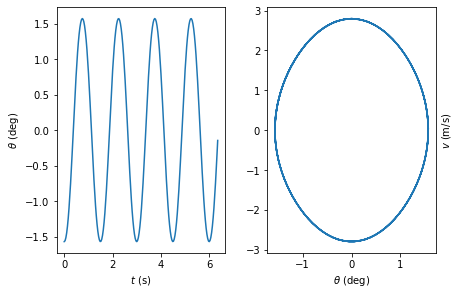

In [1]:
fig,(axtemp,axphase) = plt.subplots(1,2)
fig.tight_layout()
axtemp.plot(instants,angles)
axphase.plot(angles,vitesses)
axtemp.set_xlabel(r"$t$ (s)")
axtemp.set_ylabel(r"$\theta$ (deg)")
axphase.set_xlabel(r"$\theta$ (deg)")
axphase.set_ylabel(r"$v$ (m/s)")
axphase.yaxis.set_label_position("right")
fig.show()

## Questions du DM07



### 3a



La dériviation de l'intégrale première du mouvement par rapport au
temps permet d'établir l'équation différentielle du mouvement:
$$
\ddot{\alpha} = - \frac{g}{R} \cos\left(\alpha\right) + \frac{k}{m}
\left(\sin(\alpha) - \sin(\alpha/2)\right).
$$

On définit la nouvelle équation différentielle.



In [1]:
def systdiffDM(tau,y,omega2g,omega2k):
    alpha,alphaprime = y
    # d alpha/d t = alphaprime
    # d alphaprime / dt = - (g/R) cos(alpha) + (k/m) (sin(alpha) - sin(alpha/2))
    return [alphaprime, - omega2g * np.cos(alpha) + omega2k * ( np.sin (alpha) - np.sin(alpha/2))]
def passage_equilibre(tau,y,omega2g,omega2k):
      alpha,alphaprime=y
      return alpha-3*np.pi/4
passage_equilibre.terminal = False #pour poursuivre l'intégration
passage_equilibre.direction = 1 #pour ne compter que les passages avec theta croissant

On définit les paramètres, les pulsations caractéristiques associées
au pendule et au système masse-ressort et la période des petites
oscillations. On n'adimensionne pas l'équation ici pour vérifier
explicitement la valeur de la période des petites oscillations.



In [1]:
g = 9.8 #m/s^2
R = .1 #m
m = 5e-2 #kg
k = 15.6 #N/m
omegag = np.sqrt(g/R) # rad/s
omegak = np.sqrt(k/m) # rad/s
omega2g = omegag**2
omega2k = omegak**2

omegaDM = np.sqrt((omega2g - omega2k) * np.cos(3*np.pi/4) + (omega2k/2)* np.cos(3*np.pi/8))
TDM = 2*np.pi/omegaDM

On définit les conditions initiales et on résout.



In [1]:
alpha03a = 3*np.pi/4 - np.pi/10
alphaprime03a = 0

tmin3a,tmax3a = 0,5*TDM
CI3a = [alpha03a, alphaprime03a]

mouvement3a = solve_ivp(systdiffDM,[tmin3a,tmax3a],CI3a,max_step= TDM/50, args=[omega2g,omega2k],events=passage_equilibre)
angles3a = mouvement3a.y[0] #en rad
anglesDeg3a = angles3a*180/np.pi #en deg
instants3a= mouvement3a.t #en s
vitesses3aAng = mouvement3a.y[1] #en rad/s
vitesses3a = vitesses3aAng*R #en m/s

# Out[35]:

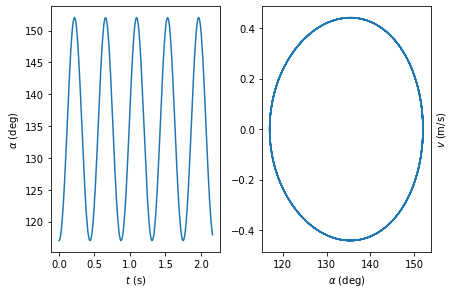

In [1]:
fig3a,(ax3atemp,ax3aphase) = plt.subplots(1,2)
fig3a.tight_layout()
ax3atemp.plot(instants3a,anglesDeg3a)
ax3aphase.plot(anglesDeg3a,vitesses3a)
ax3atemp.set_xlabel(r"$t$ (s)")
ax3atemp.set_ylabel(r"$\alpha$ (deg)")
ax3aphase.set_xlabel(r"$\alpha$ (deg)")
ax3aphase.set_ylabel(r"$v$ (m/s)")
ax3aphase.yaxis.set_label_position("right")
fig3a.show()

On remarque que même pour cette faible amplitude, on peut observer que
la trajectoire dans l'espace des phases est différente de celle d'un
oscillateur harmonique: l'extension du mouvement est en particulier
plus faible pour les $\alpha > \alpha_\text{eq}$ que pour
les $\alpha < \alpha_\text{eq}$.

On vérifie néanmoins que la période de ces oscillations est bien
proche de la période des petites oscillations déterminée précédemment.



In [1]:
f'période des petites oscillations: {TDM:.2E} s' #np.diff calcule la différence des termes consécutifs de la liste

# Out[36]:
'période des petites oscillations: 4.33E-01 s'

In [1]:
f'période pour alpha0 = {alpha03a*180/np.pi} deg: {np.mean(np.diff(mouvement3a.t_events[0])):.2E} s' #np.diff calcule la différence des termes consécutifs de la liste

# Out[37]:
'période pour alpha0 = 117.0 deg: 4.37E-01 s'

### 3b



On change simplement les conditions initiales en $\alpha_0 = \pi$.



In [1]:
alpha03b = np.pi
alphaprime03b = 0

tmin3b,tmax3b = 0,5*TDM
CI3b = [alpha03b, alphaprime03b]

mouvement3b = solve_ivp(systdiffDM,[tmin3b,tmax3b],CI3b,max_step= TDM/50, args=[omega2g,omega2k],events=passage_equilibre)
angles3b = mouvement3b.y[0] #en rad
anglesDeg3b = angles3b*180/np.pi #en deg
instants3b= mouvement3b.t #en s
vitesses3bAng = mouvement3b.y[1] #en rad/s
vitesses3b = vitesses3bAng*R #en m/s

# Out[39]:

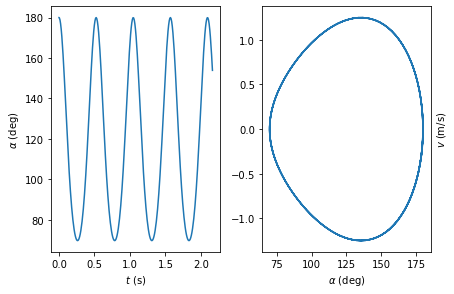

In [1]:
fig3b,(ax3btemp,ax3bphase) = plt.subplots(1,2)
fig3b.tight_layout()
ax3btemp.plot(instants3b,anglesDeg3b)
ax3bphase.plot(anglesDeg3b,vitesses3b)
ax3btemp.set_xlabel(r"$t$ (s)")
ax3btemp.set_ylabel(r"$\alpha$ (deg)")
ax3bphase.set_xlabel(r"$\alpha$ (deg)")
ax3bphase.set_ylabel(r"$v$ (m/s)")
ax3bphase.yaxis.set_label_position("right")
fig3b.show()

In [1]:
f'période pour alpha0 = {alpha03b*180/np.pi} deg: {np.mean(np.diff(mouvement3b.t_events[0])):.2E} s' #np.diff calcule la différence des termes consécutifs de la liste

# Out[40]:
'période pour alpha0 = 180.0 deg: 5.23E-01 s'

In [1]:
f'écart relatif de la période pour alpha0 = {alpha03b*180/np.pi} deg: {100*(np.mean(np.diff(mouvement3b.t_events[0]))/TDM -1):.2E} %'

# Out[41]:
'écart relatif de la période pour alpha0 = 180.0 deg: 2.10E+01 %'

Ici la trajectoire est très nettement différente de l'ellipse d'un
oscillateur harmonique et la période est notablement supérieure à
celle des petites oscillations.



### 3c



On change les conditions initiales en $\alpha_0 = \pi/4$, on utilise
l'option `terminal` de `events` pour interrompre le calcul dès qu'on
atteint $A$.



In [1]:
alpha03c = np.pi/4
alphaprime03c = 0

tmin3c,tmax3c = 0,5*TDM
CI3c = [alpha03c, alphaprime03c]

def passage_A(tau,y,omega2g,omega2k):
    alpha,alphaprime=y
    return alpha-np.pi
passage_A.terminal = True #pour poursuivre l'intégration

mouvement3c = solve_ivp(systdiffDM,[tmin3c,tmax3c],CI3c,max_step= TDM/50, args=[omega2g,omega2k],events=passage_A)
angles3c = mouvement3c.y[0] #en rad
anglesDeg3c = angles3c*180/np.pi #en deg
instants3c= mouvement3c.t #en s
vitesses3cAng = mouvement3c.y[1] #en rad/s
vitesses3c = vitesses3cAng*R #en m/s

# Out[43]:

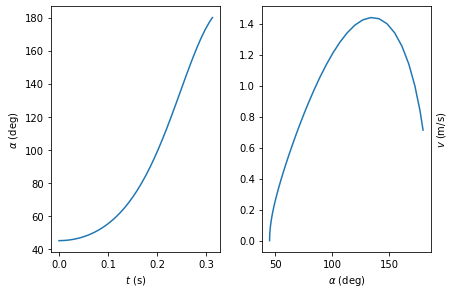

In [1]:
fig3c,(ax3ctemp,ax3cphase) = plt.subplots(1,2)
fig3c.tight_layout()
ax3ctemp.plot(instants3c,anglesDeg3c)
ax3cphase.plot(anglesDeg3c,vitesses3c)
ax3ctemp.set_xlabel(r"$t$ (s)")
ax3ctemp.set_ylabel(r"$\alpha$ (deg)")
ax3cphase.set_xlabel(r"$\alpha$ (deg)")
ax3cphase.set_ylabel(r"$v$ (m/s)")
ax3cphase.yaxis.set_label_position("right")
fig3c.show()

In [1]:
f'Durée pour atteindre B: {mouvement3c.t_events[0][0]:.2E} s'

# Out[44]:
'Durée pour atteindre B: 3.12E-01 s'

La vitesse est non nulle quand il parvient en $\alpha = \pi$.



In [1]:
f'vitesse quand il parvient en B: {mouvement3c.y_events[0][0][0]:.2E} m/s'

# Out[45]:
'vitesse quand il parvient en B: 3.14E+00 m/s'

### 3d



# Out[46]:

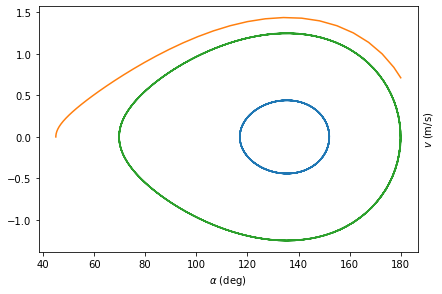

In [1]:
fig3d,ax3dphase = plt.subplots()
fig3d.tight_layout()
ax3dphase.plot(anglesDeg3a,vitesses3a)
ax3dphase.plot(anglesDeg3c,vitesses3c)
ax3dphase.plot(anglesDeg3b,vitesses3b)
ax3dphase.set_xlabel(r"$\alpha$ (deg)")
ax3dphase.set_ylabel(r"$v$ (m/s)")
ax3dphase.yaxis.set_label_position("right")
fig3d.show()